In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KDTree
#import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import random

bedrooms            2.0000
bathrooms           2.5000
sqft_living      1278.0000
view                0.0000
grade               7.0000
sqft_above       1002.0000
sqft_basement     276.0000
lat                47.5532
sqft_living15    1220.0000
Name: 13, dtype: float64 

       bedrooms  bathrooms  sqft_living  ...  sqft_basement      lat  sqft_living15
19933         2        2.5         1233  ...            270  47.5533           1230
9192          2        2.5         1250  ...            220  47.5243           1250
18439         2        2.5         1230  ...            170  47.6007           1290

[3 rows x 9 columns] 

test price:  358000 

train price: 
 [360000, 267100, 380000]


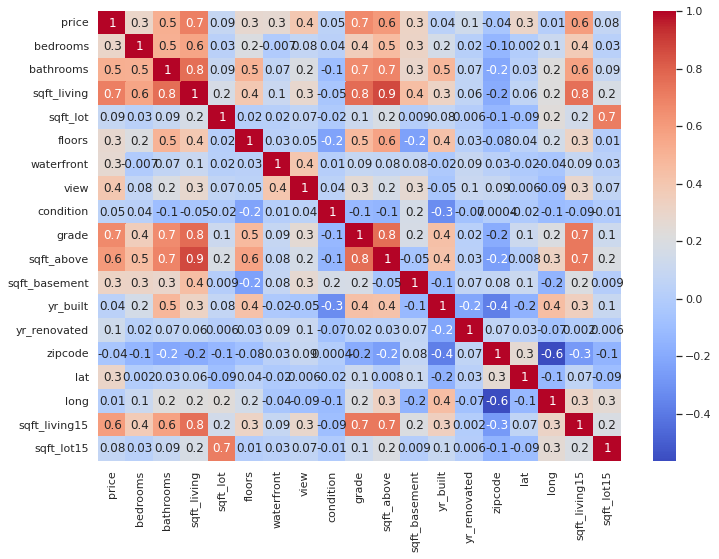

In [2]:

data = pd.read_csv("home_data-train.txt", sep = ",", header = None)
del data[0]
del data[1]

test = pd.read_excel("HomePrices-Test.xlsx", header = 0)
del test["id"]
del test ["date"]

data.columns = test.columns
train_price = data.price
del data["price"]
test_price = test.price
del test["price"]

sns.set(rc = {'figure.figsize' : (11.7, 8.27)})
corr = pd.concat([train_price, data], axis = 1).corr()
corr_map = sns.heatmap(corr, annot = True,fmt = ".1g", cmap = "coolwarm")
                       
correlated = data.columns[corr.iloc[1:, 0] >= 0.3]
scaled = StandardScaler().fit(data[correlated])
train_scaled = scaled.transform(data[correlated])
test_scaled = scaled.transform(test[correlated])

tree = KDTree(train_scaled)
nearest_dist, nearest_ind = tree.query(test_scaled[13].reshape(1, -1), k = 3)
print(test.loc[13, correlated], "\n")
print(data.loc[nearest_ind[0], correlated], "\n")
print("test price: ", test_price[13], "\n")
print("train price: \n", list(train_price[nearest_ind[0]]))


In [3]:

def inverseweight(dist, num = 1.0, const = 0.1):
    return num / (dist + const)
  
def gaussian(dist, sigma = 10.0):
    return math.e ** (- dist ** 2 / ( 2 * sigma ** 2))

def subtractweight(dist, const = 2.0):
    if dist > const:
        return 0.001
    else:
        return const - dist

def weighted_knn(kdtree, test_point, target, k = 25,
                weight_fun = inverseweight):
    nearest_dist, nearest_ind = kdtree.query(test_point, k = k)
    avg = 0.0
    totalweight = 0.0
    for i in range(k):
        dist = nearest_dist[0][i]
        idx = nearest_ind[0][i]
        weight = weight_fun(dist)
        avg += weight * target[idx]
        totalweight += weight
    avg = round(avg / totalweight)
    return avg

def testalgorithm(algo, kdtree, testset, target, test_target):
    error = 0.0
    for row in range(len(testset)):
        guess = algo(kdtree, testset[row].reshape(1, -1), target)
        error += (test_target[row] - guess) ** 2
    return round(np.sqrt(error / len(testset)))
    
random.seed(1191)
ex = random.sample(range(len(test)), 5)
print("predicted",";", "actual", " ;", "error")
for i in ex:
    res = weighted_knn(tree, test_scaled[i].reshape(1, -1), train_price)
    print(res,
         " ;", 
         test_price[i],
         " ;",
         abs(test_price[i] - res))

print(testalgorithm(weighted_knn, tree, test_scaled, train_price, test_price)) 


predicted ; actual  ; error
446422  ; 399995  ; 46427
542199  ; 653500  ; 111301
331369  ; 360000  ; 28631
375849  ; 255000  ; 120849
633987  ; 687015  ; 53028
192420
